# Baseline results: Single visit models  

### train on train subset of ses2 data from subjects with two visits. Test on ses2 and ses3 scans from test_metadata subjects. 

In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
from src.perf_utils import *

In [2]:
data_dir = "/home/nikhil/projects/brain_changes/data/"
exp_setup_dir = f"{data_dir}exp_setup"

ukbb_dir = f"{exp_setup_dir}/ukbb/"
adni_dir = f"{exp_setup_dir}/adni/"

# UKB Paths
ukbb_demographics_csv = f"{ukbb_dir}ukbb_exp_data_demographics.csv" 
ukbb_DKT_csv = f"{ukbb_dir}ukbb_exp_data_DKT.csv" 
ukbb_exp_setup_csv = f"{ukbb_dir}ukbb_exp_setup_shortterm.csv"

# ADNI Paths
adni_demographics_csv = f"{adni_dir}adni_exp_data_demographics.csv" 
adni_DKT_csv = f"{adni_dir}adni_exp_data_DKT.csv" 

# DKT fields and labels
ukbb_dkt_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_ASEG_vol_Fields.csv"

### UKB short-term data
#### Labels
    - "age_at_ses2" --> age rounded in years 
    - "age_at_ses2 (calc)" --> floating point age calculated from years and months

#### Setups (input (dkt) --> output (age))
    - BL --> BL 
    - BL + FU --> BL
    - BL + FU --> BL + FU



#### Global configs

In [3]:

age_ses2_col = "age_at_ses2 (calc)" # "age_at_ses2" or "age_at_ses2 (calc)"
age_ses3_col = "age_at_ses3 (calc)" # "age_at_ses3" or "age_at_ses3 (calc)"

use_sex_col = False # Doesn't help much

DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)


### visit configs for the experiments

In [4]:
# Setup
exp_setup_dict = {
    "exp: BL-->BL": {"input":["ses-2"],
                     "output":[age_ses2_col]},
    "exp: BL+FU-->BL": {"input":["ses-2","ses-3"],
                        "output":[age_ses2_col]},
    "exp: BL+FU-->BL+FU": {"input":["ses-2","ses-3"],
                        "output":[age_ses2_col,age_ses3_col]},                                             
}

n_jobs = 4
model_dict = {
            "Ridge": Ridge(), 
            # "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1)
            }

### Load data and run models

In [6]:
ukbb_exp_setup_df = pd.read_csv(ukbb_exp_setup_csv)
train_ids = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "train"]["participant_id"].values
val_ids = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "val"]["participant_id"].values
print(f"n_train: {len(train_ids)}, n_val: {len(val_ids)}")

exp_perf_df = pd.DataFrame()
for exp_name, exp_setup in exp_setup_dict.items():
    print(f"\nexp name: {exp_name}")
    age_cols = exp_setup["output"]

    # Slice demographic cols
    demo_cols = ["participant_id","sex"] + age_cols
    train_demographics_df = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "train"][demo_cols]
    train_demographics_df = train_demographics_df.rename(columns={"participant_id":"subject_id"})
    val_demographics_df = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "val"][demo_cols]
    val_demographics_df = val_demographics_df.rename(columns={"participant_id":"subject_id"})

    # Read DKT
    DKT_df = pd.read_csv(ukbb_DKT_csv)
    train_ses2_DKT_df = DKT_df[(DKT_df["subject_id"].isin(train_ids)) & (DKT_df["session"] == "ses-2")]
    val_ses2_DKT_df = DKT_df[(DKT_df["subject_id"].isin(val_ids)) & (DKT_df["session"] == "ses-2")]                                

    train_ses3_DKT_df = DKT_df[(DKT_df["subject_id"].isin(train_ids)) & (DKT_df["session"] == "ses-3")]
    val_ses3_DKT_df = DKT_df[(DKT_df["subject_id"].isin(val_ids)) & (DKT_df["session"] == "ses-3")] 

    if exp_name == "exp: BL-->BL":
        train_DKT_df = train_ses2_DKT_df
        val_DKT_df = val_ses2_DKT_df
        feature_cols = DKT_fields_sorted

        # Additional val_df (for the FU visit)
        val_FU_DKT_df = val_ses3_DKT_df
        val_FU_demographics_df = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "val"][["participant_id","sex",age_ses3_col]]
        val_FU_demographics_df = val_FU_demographics_df.rename(columns={"participant_id":"subject_id"})
        val_FU_df = pd.merge(val_FU_DKT_df, val_FU_demographics_df, on="subject_id")
        val_FU_df = val_FU_df.sort_values(by="subject_id")
        X_val_FU = val_FU_df[feature_cols].values
        y_val_FU = np.squeeze(val_FU_df[age_ses3_col].values)

    else:
        train_DKT_df = pd.merge(train_ses2_DKT_df, train_ses3_DKT_df, on="subject_id")
        val_DKT_df = pd.merge(val_ses2_DKT_df, val_ses3_DKT_df, on="subject_id")
        feature_cols = [f"{dkt_field}_x" for dkt_field in DKT_fields_sorted] + [f"{dkt_field}_y" for dkt_field in DKT_fields_sorted] 
        X_val_FU = None
        y_val_FU = None

    if use_sex_col:
        feature_cols = feature_cols + ["sex"]
        print("Using sex column as input")
        
    # merge with demographic df
    train_df = pd.merge(train_DKT_df, train_demographics_df, on="subject_id")
    val_df = pd.merge(val_DKT_df, val_demographics_df, on="subject_id")
    val_df = val_df.sort_values(by="subject_id")

    X_train = train_df[feature_cols].values
    y_train = np.squeeze(train_df[age_cols].values)

    print(f"shapes X_CV: {X_train.shape}, y_CV: {y_train.shape}")

    X_val = val_df[feature_cols].values
    y_val = np.squeeze(val_df[age_cols].values)

    print(f"shapes  X_val: {X_val.shape}, y_val: {y_val.shape}")

    model_perf_df = pd.DataFrame()
    for model_name, model_instance in model_dict.items():
        perf_df = get_brain_age_perf(model_instance, X_train, y_train, X_val, y_val, X_val_FU, y_val_FU, cv=2)
        perf_df["model"] = model_name
        model_perf_df = model_perf_df.append(perf_df)

    model_perf_df["exp_name"] = exp_name
    exp_perf_df = exp_perf_df.append(model_perf_df)


n_train: 3071, n_val: 342

exp name: exp: BL-->BL
shapes X_CV: (3071, 62), y_CV: (3071,)
shapes  X_val: (342, 62), y_val: (342,)

exp name: exp: BL+FU-->BL
shapes X_CV: (3071, 124), y_CV: (3071,)
shapes  X_val: (342, 124), y_val: (342,)

exp name: exp: BL+FU-->BL+FU
shapes X_CV: (3071, 124), y_CV: (3071, 2)
shapes  X_val: (342, 124), y_val: (342, 2)


In [7]:
exp_perf_df.groupby(["exp_name","model"]).mean().reset_index()

,exp_name,model,y_test_BL,y_pred_BL,sq_err_BL,abs_err_BL,corr_BL,y_test_FU,y_pred_FU,sq_err_FU,abs_err_FU,corr_FU,delta_test,delta_pred
0,exp: BL+FU-->BL,Ridge,63.224854,62.998657,36.040735,4.825583,0.574869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,exp: BL+FU-->BL+FU,Ridge,63.224854,62.998657,36.040735,4.825583,0.574869,65.509649,65.288483,36.196149,4.847468,0.571192,2.284795,2.289826
2,exp: BL-->BL,Ridge,63.224854,62.916859,38.682924,5.082880,0.531193,65.509649,63.526399,41.883957,5.238608,0.541096,2.284795,0.609540


## Plots

### Absolute or squared error

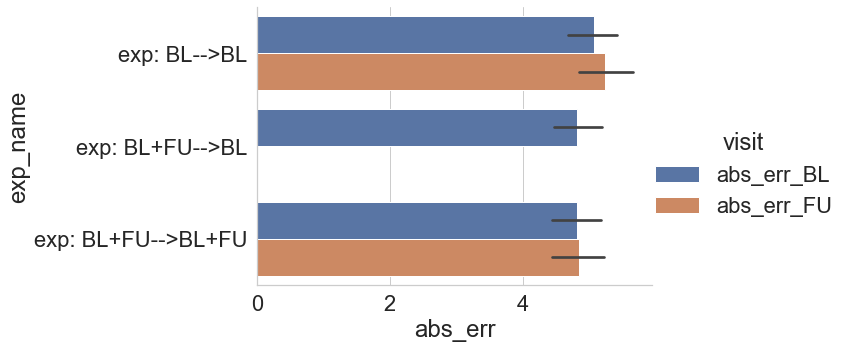

In [8]:
err_type = "abs_err"
plot_df = exp_perf_df[["model","exp_name",f"{err_type}_BL",f"{err_type}_FU"]].copy()

plot_df_melt = plot_df.melt(
    id_vars = ["model","exp_name"],
    var_name = "visit", 
    value_name = err_type,
)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x=err_type,y="exp_name", hue="visit", kind="bar", data=plot_df_melt, aspect=2)

### Brain Ageing consistency (temporal stability)

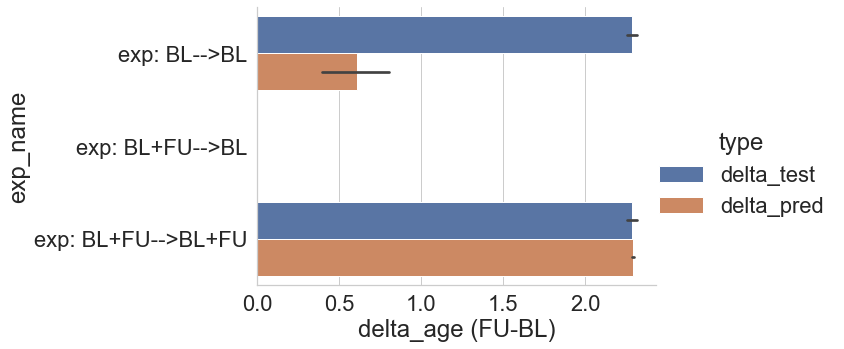

In [9]:
plot_df = exp_perf_df[["model","exp_name","delta_test","delta_pred"]].copy()

plot_df_melt = plot_df.melt(
    id_vars = ["model","exp_name"],
    var_name = "type", 
    value_name = "delta_age (FU-BL)",
)
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="delta_age (FU-BL)",y="exp_name", hue="type", kind="bar", data=plot_df_melt, aspect=2)

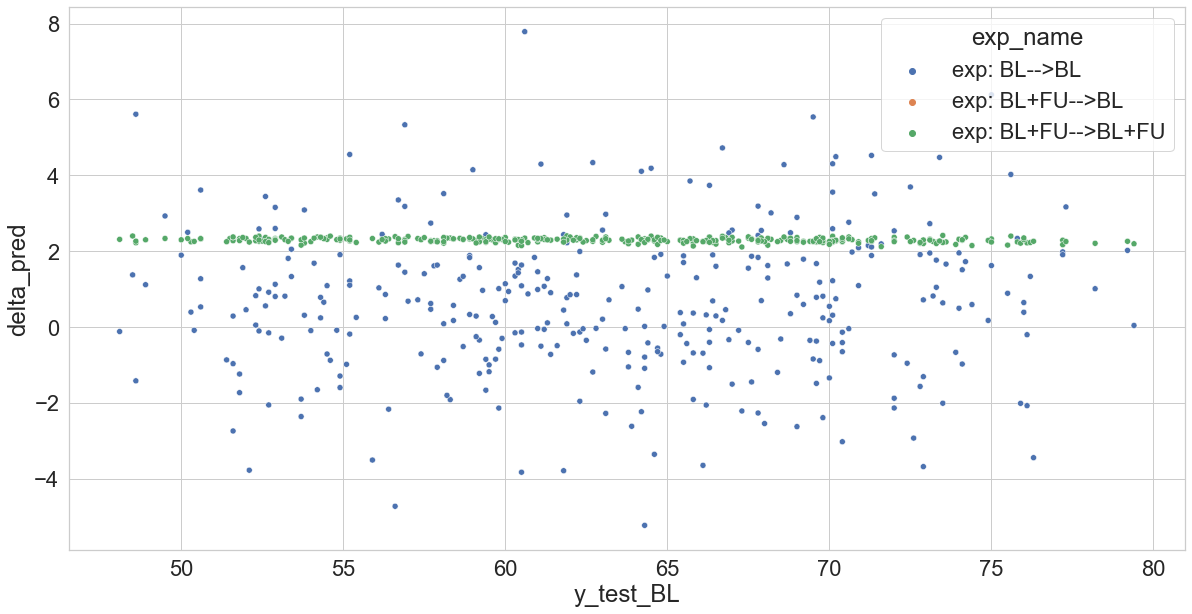

In [14]:
exp_list = ["exp: BL-->BL","exp: BL+FU-->BL+FU"]
plot_df = exp_perf_df[exp_perf_df["exp_name"].isin(exp_list)][["model","exp_name","y_test_BL","delta_pred"]].copy()

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    g = sns.scatterplot(x="y_test_BL", y="delta_pred", hue="exp_name", data=plot_df, ax=ax)

# features: ses-2 
    # without sex col
    # model: Ridge, val mae: 5.083, correlation: 0.531
    # model: RF, val mae: 5.436, correlation: 0.445

    # with sex col
    # model: Ridge, val mae: 5.085, correlation: 0.531
    # model: RF, val mae: 5.458, correlation: 0.436

# features: ses-2 and 3 
    # without sex col
    # model: Ridge, val mae: 4.826, correlation: 0.575

    # with sex col
    # model: Ridge, val mae: 4.820, correlation: 0.574